# HMM

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import librosa


In [90]:
path_to_spoken_digit_dataset = "../../data/external/spoken_digit_dataset"

def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

def get_digits_mfcc_data(path_to_spoken_digit_dataset):
    digit_mfcc_accum = {str(i): [] for i in range(10)}

    files = os.listdir(path_to_spoken_digit_dataset)
    for file_name in files:
        if file_name.endswith(".wav"):
            digit = file_name.split('_')[0]
            file_path = os.path.join(path_to_spoken_digit_dataset, file_name)
            mfccs = extract_mfcc(file_path)
            digit_mfcc_accum[digit].append(mfccs)

    return digit_mfcc_accum

digit_mfcc_accum = get_digits_mfcc_data(path_to_spoken_digit_dataset)


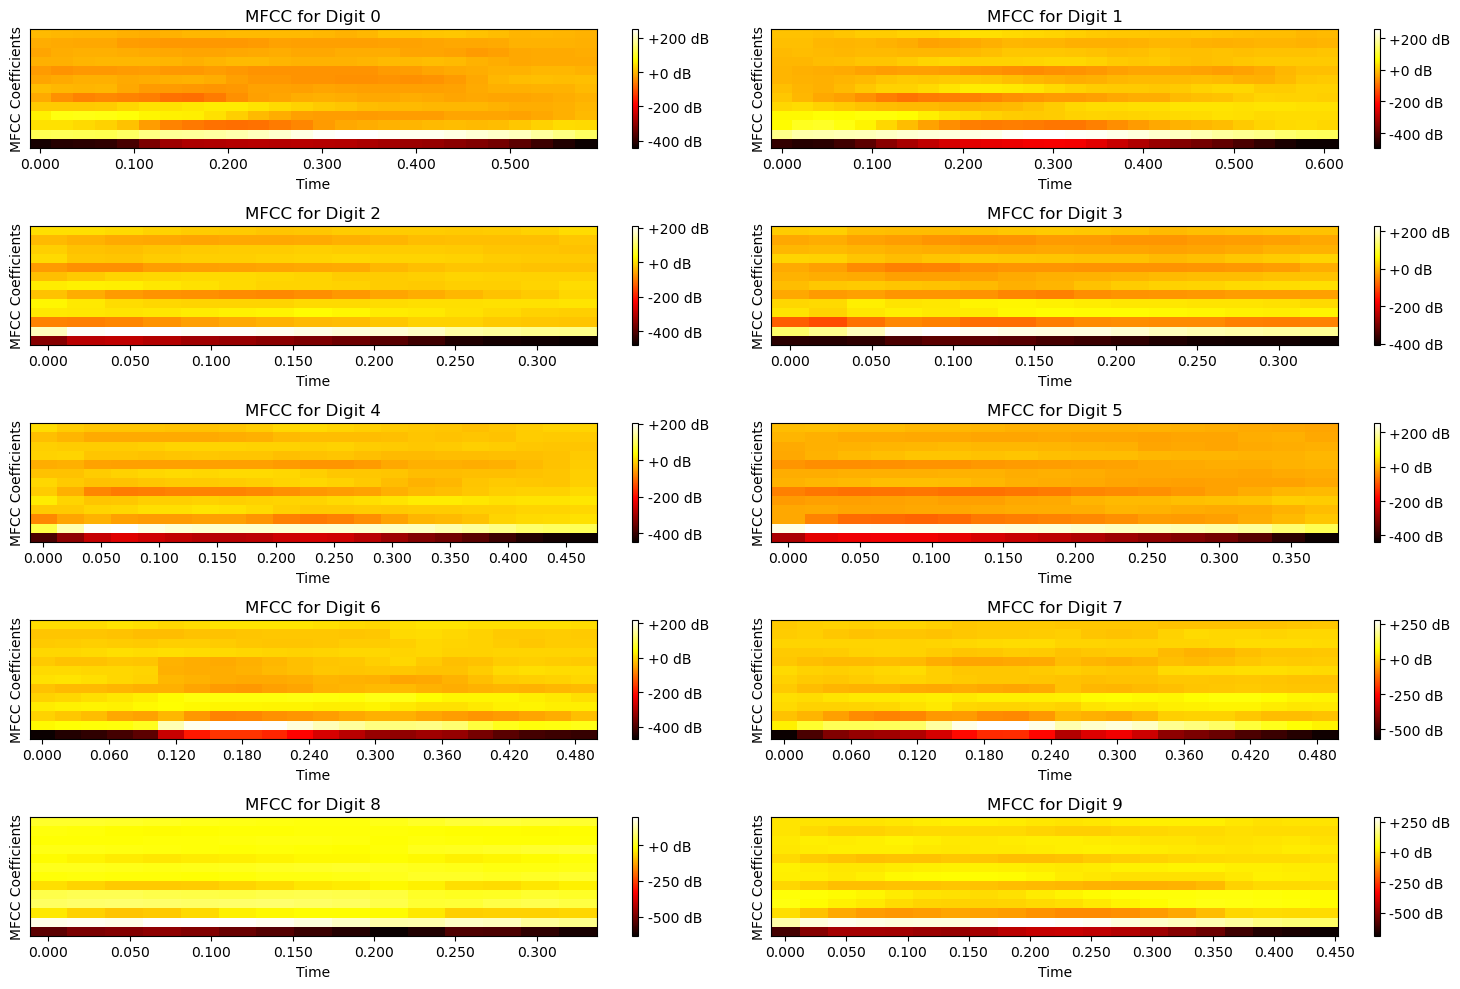

In [79]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (digit, mfcc_list) in enumerate(digit_mfcc_accum.items()):
    if mfcc_list:
        # a random number(0 to 299 - 300 audios per digit) is chosen here to display the mfcc of the digit  
        sample_mfcc = mfcc_list[25].T
        ax = axes[i]
        img = librosa.display.specshow(sample_mfcc, x_axis='time', ax=ax, cmap='hot')
        plt.colorbar(img, ax=ax, format="%+2.0f dB")
        ax.set_title(f"MFCC for Digit {digit}")
        ax.set_xlabel("Time")
        ax.set_ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

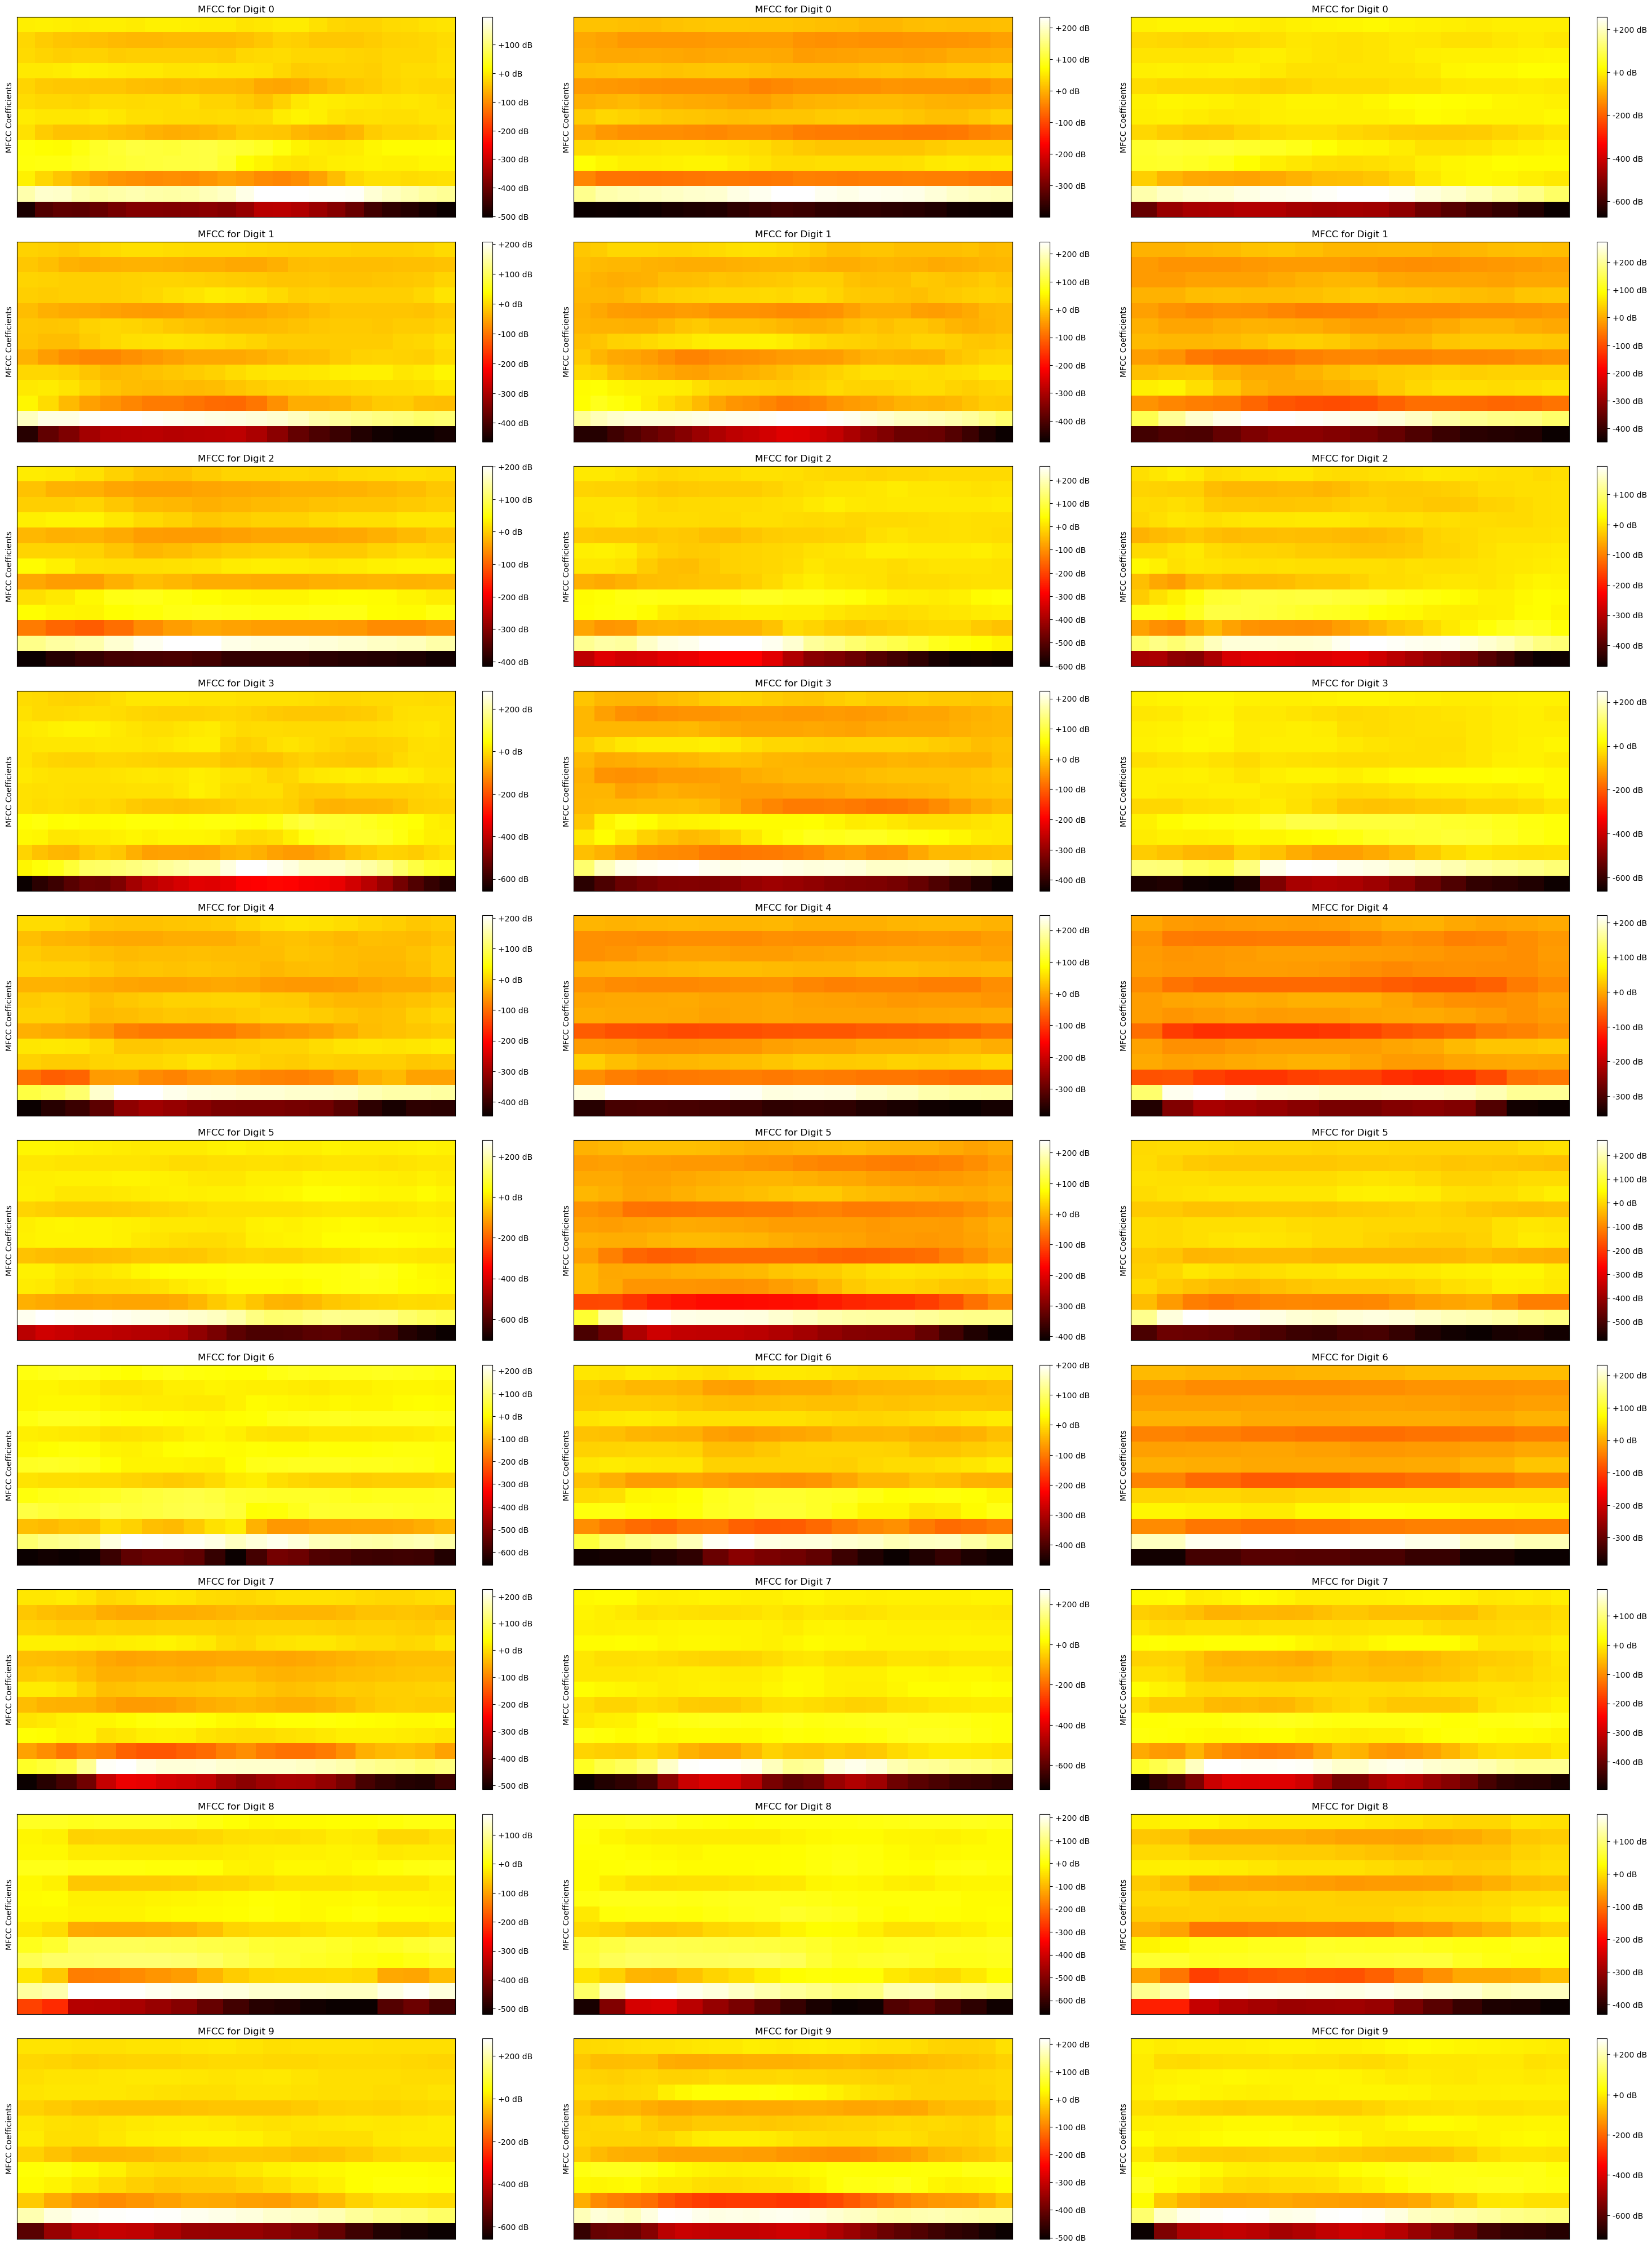

In [129]:
# for every digit plot 3 random mfccs
fig, axes = plt.subplots(10, 3, figsize=(30, 40))
axes = axes.ravel()

for i, (digit, mfcc_list) in enumerate(digit_mfcc_accum.items()):
    if mfcc_list:
        for j in range(3):
            sample_mfcc = mfcc_list[np.random.randint(0, len(mfcc_list))].T
            ax = axes[i*3+j]
            img = librosa.display.specshow(sample_mfcc, ax=ax, cmap='hot')
            plt.colorbar(img, ax=ax, format="%+2.0f dB")
            ax.set_title(f"MFCC for Digit {digit}")
            # ax.set_xlabel("Time")
            ax.set_ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

In [80]:
def split_train_test(digit_mfcc_accum):    
    train_data = {}
    test_data = {}

    for digit, mfcc_list in digit_mfcc_accum.items():
        n = len(mfcc_list)
        n_train = int(0.8 * n)
        np.random.shuffle(mfcc_list)
        train_data[digit] = mfcc_list[:n_train]
        test_data[digit] = mfcc_list[n_train:]

    return train_data, test_data

train_data, test_data = split_train_test(digit_mfcc_accum)


In [86]:
from hmmlearn import hmm

class HMM:
    def __init__(self, num_of_digits=10):
        self.models = {}
        self.num_of_digits = num_of_digits

    def train(self, train_data, n_components=10, n_iter=100):
        for digit, mfcc_list in train_data.items():
            model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=n_iter)
            X = np.concatenate(mfcc_list)
            model.fit(X)
            self.models[digit] = model

    def predict(self, test_data):
        preds = []
        for mcff in test_data:
            scores = [model.score(mcff) for model in self.models.values()]
            pred = np.argmax(scores)
            preds.append(pred)
        return preds
    


In [85]:
hmm_model = HMM()

hmm_model.train(train_data)

In [89]:
def evaluate_model(model, test_data):
    preds = []
    true_labels = []
    for digit, mfcc_list in test_data.items():
        pred = model.predict(mfcc_list)
        preds.extend(pred)
        true_labels.extend([int(digit)] * len(pred))
    return true_labels, preds

true_labels, preds = evaluate_model(hmm_model, test_data)


accuracy = np.mean(np.array(true_labels) == np.array(preds))

print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 91.17%


In [116]:
path_to_my_recorded_digits = "../../data/external/my_recorded_digits"

def test_my_recorded_digits(data_path=path_to_my_recorded_digits, model=hmm_model):
    targets = []
    preds = []
    for file_name in os.listdir(data_path):
        if file_name.endswith(".wav"):
            digit = file_name.split('.')[0]
            file_path = os.path.join(data_path, file_name)
            mfccs = extract_mfcc(file_path)
            pred = model.predict([mfccs])
            preds.extend(pred)
            targets.extend([int(digit)] * len(pred))
    return targets, preds

targets, preds = test_my_recorded_digits()

print("Targets:", targets)
print("Predictions:", preds)

accuracy = np.mean(np.array(targets) == np.array(preds))
print(f"Accuracy: {accuracy*100:.2f}%")

Targets: [9, 8, 6, 7, 5, 4, 0, 1, 3, 2]
Predictions: [1, 8, 1, 1, 1, 1, 7, 5, 3, 1]
Accuracy: 20.00%


The accuracy on known test set is more than 90% whereas the accuracy on my recorded set of audios is very less (< 50%). The reason is the difference in the way the audios are (the accent, the speed, the noise, etc.). Since the known test set contains audios from the same set of people whose data is used during training, the model is able to predict the digits correctly. But when the audios are from different people than the training data(like me), the model is not able to predict the digits correctly. This is the limitation of hmm model where it is not able to generalize well on diverse audio inputs.